In [1]:
path_data = '../../data/'

import numpy as np
import pandas as pd
import math
import scipy.stats as stats

%matplotlib inline
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
plt.style.use('fivethirtyeight')

import warnings
warnings.filterwarnings('ignore')

# Implementing the Classifier
We are now ready to implement a $k$-nearest neighbor classifier based on multiple attributes. We have used only two attributes so far, for ease of visualization. But usually predictions will be based on many attributes. Here is an example that shows how multiple attributes can be better than pairs.

## Banknote authentication

This time we'll look at predicting whether a banknote (e.g., a \$20 bill) is counterfeit or legitimate.  Researchers have put together a data set for us, based on photographs of many individual banknotes: some counterfeit, some legitimate.  They computed a few numbers from each image, using techniques that we won't worry about for this course.  So, for each banknote, we know a few numbers that were computed from a photograph of it as well as its class (whether it is counterfeit or not).  Let's load it into a table and take a look.

In [2]:
banknotes = pd.read_csv(path_data + 'banknote.csv')
banknotes

WaveletVar  WaveletSkew  WaveletCurt  Entropy  Class
0        3.62160      8.66610      -2.8073 -0.44699      0
1        4.54590      8.16740      -2.4586 -1.46210      0
2        3.86600     -2.63830       1.9242  0.10645      0
3        3.45660      9.52280      -4.0112 -3.59440      0
4        0.32924     -4.45520       4.5718 -0.98880      0
...          ...          ...          ...      ...    ...
1367     0.40614      1.34920      -1.4501 -0.55949      1
1368    -1.38870     -4.87730       6.4774  0.34179      1
1369    -3.75030    -13.45860      17.5932 -2.77710      1
1370    -3.56370     -8.38270      12.3930 -1.28230      1
1371    -2.54190     -0.65804       2.6842  1.19520      1

[1372 rows x 5 columns]

Let's look at whether the first two numbers tell us anything about whether the banknote is counterfeit or not.  Here's a scatterplot:

In [3]:
color_table = pd.DataFrame(
    {'Class':np.array([1, 0]),
    'Color':np.array(['darkblue', 'gold'])}
)

In [4]:
banknotes = pd.merge(banknotes, color_table, on='Class')
banknotes

WaveletVar  WaveletSkew  WaveletCurt  Entropy  Class     Color
0        3.62160      8.66610      -2.8073 -0.44699      0      gold
1        4.54590      8.16740      -2.4586 -1.46210      0      gold
2        3.86600     -2.63830       1.9242  0.10645      0      gold
3        3.45660      9.52280      -4.0112 -3.59440      0      gold
4        0.32924     -4.45520       4.5718 -0.98880      0      gold
...          ...          ...          ...      ...    ...       ...
1367     0.40614      1.34920      -1.4501 -0.55949      1  darkblue
1368    -1.38870     -4.87730       6.4774  0.34179      1  darkblue
1369    -3.75030    -13.45860      17.5932 -2.77710      1  darkblue
1370    -3.56370     -8.38270      12.3930 -1.28230      1  darkblue
1371    -2.54190     -0.65804       2.6842  1.19520      1  darkblue

[1372 rows x 6 columns]

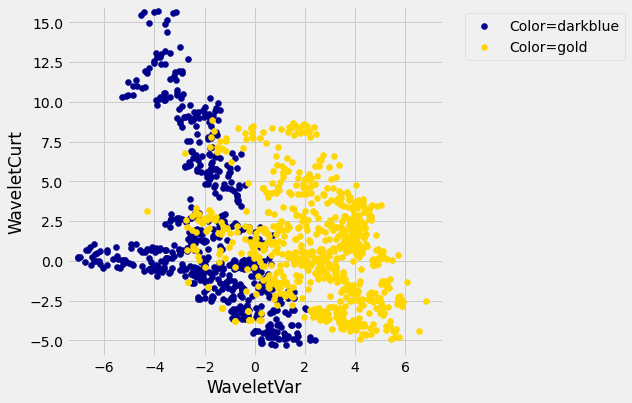

In [5]:
banknotes_darkblue = banknotes[banknotes['Color'] == 'darkblue']
banknotes_gold = banknotes[banknotes['Color'] == 'gold']


fig, ax = plt.subplots(figsize=(6,6))

ax.scatter(banknotes_darkblue['WaveletVar'], 
           banknotes_darkblue['WaveletCurt'],  
           label='Color=darkblue', 
           color='darkblue')

ax.scatter(banknotes_gold['WaveletVar'], 
           banknotes_gold['WaveletCurt'],  
           label='Color=gold', 
           color='gold')


x_label = 'WaveletVar'

y_label = 'WaveletCurt'

y_vals = ax.get_yticks()

plt.ylabel(y_label)

plt.xlabel(x_label)

ax.legend(bbox_to_anchor=(1.04,1), loc="upper left")

plt.xlim(-7.5, 7.5)
plt.ylim(-6, 16)

plt.show()


Pretty interesting!  Those two measurements do seem helpful for predicting whether the banknote is counterfeit or not.  However, in this example you can now see that there is some overlap between the blue cluster and the gold cluster.  This indicates that there will be some images where it's hard to tell whether the banknote is legitimate based on just these two numbers.  Still, you could use a $k$-nearest neighbor classifier to predict the legitimacy of a banknote.

Take a minute and think it through: Suppose we used $k=11$ (say).  What parts of the plot would the classifier get right, and what parts would it make errors on?  What would the decision boundary look like?

The patterns that show up in the data can get pretty wild.  For instance, here's what we'd get if used a different pair of measurements from the images:

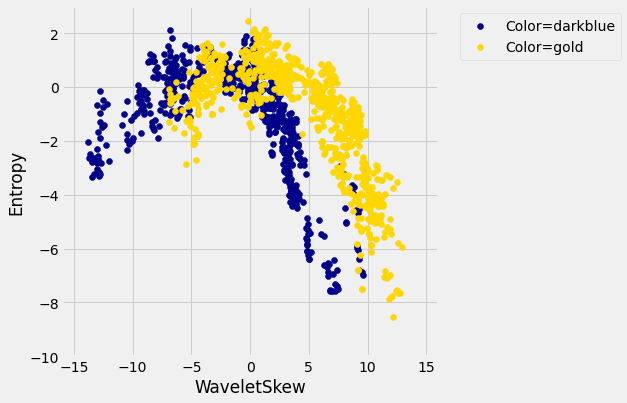

In [6]:
banknotes_darkblue = banknotes[banknotes['Color'] == 'darkblue']
banknotes_gold = banknotes[banknotes['Color'] == 'gold']


fig, ax = plt.subplots(figsize=(6,6))

ax.scatter(banknotes_darkblue['WaveletSkew'], 
           banknotes_darkblue['Entropy'],  
           label='Color=darkblue', 
           color='darkblue')

ax.scatter(banknotes_gold['WaveletSkew'], 
           banknotes_gold['Entropy'],  
           label='Color=gold', 
           color='gold')


x_label = 'WaveletSkew'

y_label = 'Entropy'

y_vals = ax.get_yticks()

plt.ylabel(y_label)

plt.xlabel(x_label)

ax.legend(bbox_to_anchor=(1.04,1), loc="upper left")

plt.xlim(-16, 16)
plt.ylim(-10, 3)

plt.show()


There does seem to be a pattern, but it's a pretty complex one.  Nonetheless, the $k$-nearest neighbors classifier can still be used and will effectively "discover" patterns out of this.  This illustrates how powerful machine learning can be: it can effectively take advantage of even patterns that we would not have anticipated, or that we would have thought to "program into" the computer.

### Multiple attributes
So far I've been assuming that we have exactly 2 attributes that we can use to help us make our prediction.  What if we have more than 2?  For instance, what if we have 3 attributes?

Here's the cool part: you can use the same ideas for this case, too.  All you have to do is make a 3-dimensional scatterplot, instead of a 2-dimensional plot.  You can still use the $k$-nearest neighbors classifier, but now computing distances in 3 dimensions instead of just 2.  It just works.  Very cool!

In fact, there's nothing special about 2 or 3.  If you have 4 attributes, you can use the $k$-nearest neighbors classifier in 4 dimensions.  5 attributes?  Work in 5-dimensional space.  And no need to stop there!  This all works for arbitrarily many attributes; you just work in a very high dimensional space.  It gets wicked-impossible to visualize, but that's OK.  The computer algorithm generalizes very nicely: all you need is the ability to compute the distance, and that's not hard.  Mind-blowing stuff!

For instance, let's see what happens if we try to predict whether a banknote is counterfeit or not using 3 of the measurements, instead of just 2.  Here's what you get:

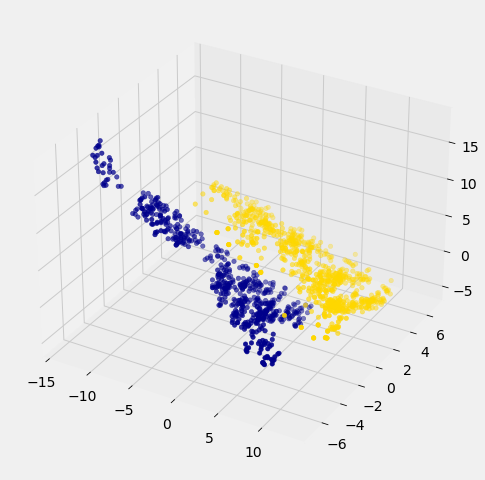

In [7]:
ax = plt.figure(figsize=(8,8)).add_subplot(111, projection='3d')
ax.scatter(banknotes['WaveletSkew'], 
           banknotes['WaveletVar'], 
           banknotes['WaveletCurt'], 
           c=banknotes['Color']);

Awesome!  With just 2 attributes, there was some overlap between the two clusters (which means that the classifier was bound to make some mistakes for pointers in the overlap).  But when we use these 3 attributes, the two clusters have almost no overlap.  In other words, a classifier that uses these 3 attributes will be more accurate than one that only uses the 2 attributes.

This is a general phenomenom in classification.  Each attribute can potentially give you new information, so more attributes sometimes helps you build a better classifier.  Of course, the cost is that now we have to gather more information to measure the value of each attribute, but this cost may be well worth it if it significantly improves the accuracy of our classifier.

To sum up: you now know how to use $k$-nearest neighbor classification to predict the answer to a yes/no question, based on the values of some attributes, assuming you have a training set with examples where the correct prediction is known.  The general roadmap is this:

1. identify some attributes that you think might help you predict the answer to the question.
2. Gather a training set of examples where you know the values of the attributes as well as the correct prediction.
3. To make predictions in the future, measure the value of the attributes and then use $k$-nearest neighbor classification to predict the answer to the question.

### Distance in Multiple Dimensions
We know how to compute distance in 2-dimensional space. If we have a point at coordinates $(x_0,y_0)$ and another at $(x_1,y_1)$, the distance between them is

$$D = \sqrt{(x_0-x_1)^2 + (y_0-y_1)^2}.$$

In 3-dimensional space, the points are $(x_0, y_0, z_0)$ and $(x_1, y_1, z_1)$, and the formula for the distance between them is

$$
D = \sqrt{(x_0-x_1)^2 + (y_0-y_1)^2 + (z_0-z_1)^2}
$$

In $n$-dimensional space, things are a bit harder to visualize, but I think you can see how the formula generalized: we sum up the squares of the differences between each individual coordinate, and then take the square root of that.  

In the last section, we defined the function `distance` which returned the distance between two points. We used it in two-dimensions, but the great news is that the function doesn't care how many dimensions there are! It just subtracts the two arrays of coordinates (no matter how long the arrays are), squares the differences and adds up, and then takes the square root. To work in multiple dimensions, we don't have to change the code at all.

In [8]:
def distance(point1, point2):
    """Returns the distance between point1 and point2
    where each argument is an array 
    consisting of the coordinates of the point"""
    return np.sqrt(np.sum((point1 - point2)**2))

Let's use this on a [new dataset](https://archive.ics.uci.edu/ml/datasets/Wine). The table `wine` contains the chemical composition of 178 different Italian wines. The classes are the grape species, called cultivars. There are three classes but let's just see whether we can tell Class 1 apart from the other two.

In [9]:
wine = pd.read_csv(path_data + 'wine.csv')

# For converting Class to binary

def is_one(x):
    if x == 1:
        return 1
    else:
        return 0

wine['Class1'] = wine['Class'].apply(is_one)

# This creates a column 'Class1' - we drop the 'Class' column, rename 'Class1' as 'Class'
# then move the column to the first position using 'pop' and 'insert'

wine = wine.drop(columns=['Class'])

wine = wine.rename(columns={'Class1': 'Class'})

class_label = wine.pop('Class')

wine.insert(0, 'Class', class_label)


In [10]:
wine

Class  Alcohol  Malic Acid   Ash  Alcalinity of Ash  Magnesium  \
0        1    14.23        1.71  2.43               15.6        127   
1        1    13.20        1.78  2.14               11.2        100   
2        1    13.16        2.36  2.67               18.6        101   
3        1    14.37        1.95  2.50               16.8        113   
4        1    13.24        2.59  2.87               21.0        118   
..     ...      ...         ...   ...                ...        ...   
173      0    13.71        5.65  2.45               20.5         95   
174      0    13.40        3.91  2.48               23.0        102   
175      0    13.27        4.28  2.26               20.0        120   
176      0    13.17        2.59  2.37               20.0        120   
177      0    14.13        4.10  2.74               24.5         96   

     Total Phenols  Flavanoids  Nonflavanoid phenols  Proanthocyanins  \
0             2.80        3.06                  0.28             2.29   
1             2.65        2.76                  0.26             1.28   
2             2.80        3.24                  0.30             2.81   
3             3.85        3.49                  0.24             2.18   
4             2.80        2.69                  0.39             1.82   
..             ...         ...                   ...              ...   
173           1.68        0.61                  0.52             1.06   
174           1.80        0.75                  0.43             1.41   
175           1.59        0.69                  0.43             1.35   
176           1.65        0.68                  0.53             1.46   
177           2.05        0.76                  0.56             1.35   

     Color Intensity   Hue  OD280/OD315 of diulted wines  Proline  
0               5.64  1.04                          3.92     1065  
1               4.38  1.05                          3.40     1050  
2               5.68  1.03                          3.17     1185  
3               7.80  0.86                          3.45     1480  
4               4.32  1.04                          2.93      735  
..               ...   ...                           ...      ...  
173             7.70  0.64                          1.74      740  
174             7.30  0.70                          1.56      750  
175            10.20  0.59                          1.56      835  
176             9.30  0.60                          1.62      840  
177             9.20  0.61                          1.60      560  

[178 rows x 14 columns]

The first two wines are both in Class 1. To find the distance between them, we first need a table of just the attributes:

In [11]:
wine_attributes = wine.copy()

wine_attributes = wine_attributes.drop(columns=['Class'])

In [12]:
distance(np.array(wine_attributes.iloc[0]), np.array(wine_attributes.iloc[1]))

31.265012394048398

The last wine in the table is of Class 0. Its distance from the first wine is:

In [13]:
distance(np.array(wine_attributes.iloc[0]), np.array(wine_attributes.iloc[177]))

506.05936766351834

That's quite a bit bigger! Let's do some visualization to see if Class 1 really looks different from Class 0. 

In [14]:
wine_with_colors = pd.merge(wine, color_table, on='Class')

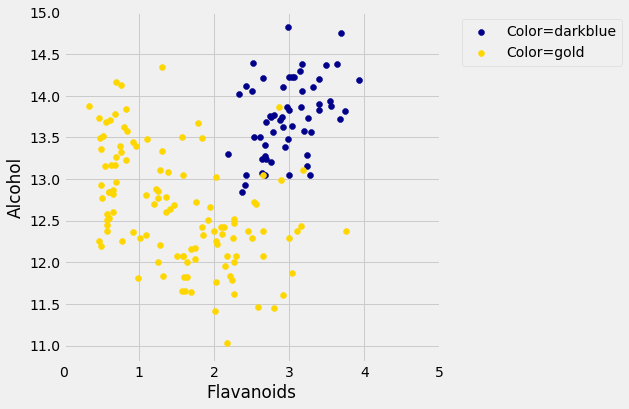

In [15]:
wine_darkblue = wine_with_colors[wine_with_colors['Color'] == 'darkblue']
wine_gold = wine_with_colors[wine_with_colors['Color'] == 'gold']

fig, ax = plt.subplots(figsize=(6,6))

ax.scatter(wine_darkblue['Flavanoids'], 
           wine_darkblue['Alcohol'],  
           label='Color=darkblue', 
           color='darkblue')

ax.scatter(wine_gold['Flavanoids'], 
           wine_gold['Alcohol'],  
           label='Color=gold', 
           color='gold')


x_label = 'Flavanoids'

y_label = 'Alcohol'

#y_vals = ax.get_yticks()

plt.ylabel(y_label)

plt.xlabel(x_label)

ax.legend(bbox_to_anchor=(1.04,1), loc="upper left")

plt.xlim(0, 5)
plt.ylim(10.8, 15)

plt.show()


The blue points (Class 1) are almost entirely separate from the gold ones. That is one indication of why the distance between two Class 1 wines would be smaller than the distance between wines of two different classes. We can see a similar phenomenon with a different pair of attributes too:

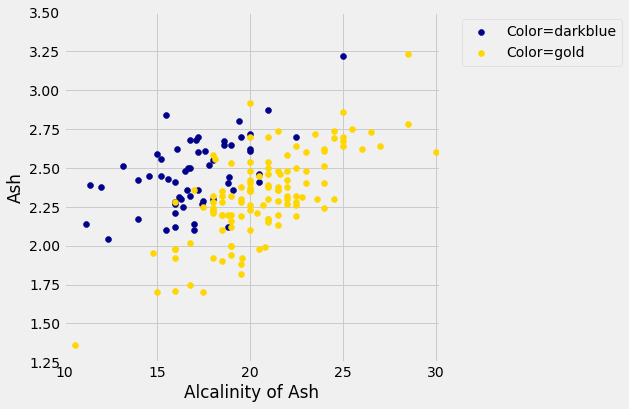

In [16]:
wine_darkblue = wine_with_colors[wine_with_colors['Color'] == 'darkblue']
wine_gold = wine_with_colors[wine_with_colors['Color'] == 'gold']

fig, ax = plt.subplots(figsize=(6,6))

ax.scatter(wine_darkblue['Alcalinity of Ash'], 
           wine_darkblue['Ash'],  
           label='Color=darkblue', 
           color='darkblue')

ax.scatter(wine_gold['Alcalinity of Ash'], 
           wine_gold['Ash'],  
           label='Color=gold', 
           color='gold')


x_label = 'Alcalinity of Ash'

y_label = 'Ash'

#y_vals = ax.get_yticks()

plt.ylabel(y_label)

plt.xlabel(x_label)

ax.legend(bbox_to_anchor=(1.04,1), loc="upper left")

plt.xlim(10, 30.2)
plt.ylim(1.25, 3.5)

plt.show()


But for some pairs the picture is more murky.

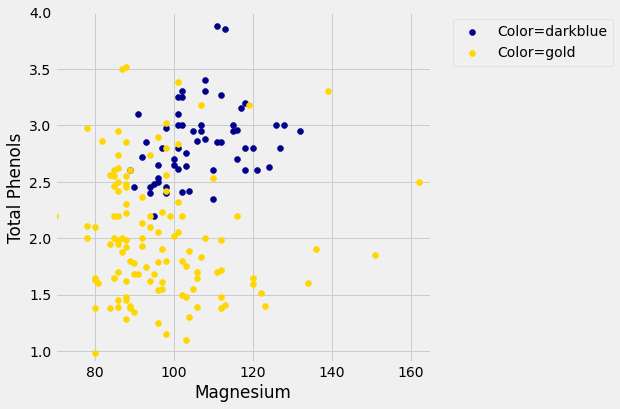

In [17]:
wine_darkblue = wine_with_colors[wine_with_colors['Color'] == 'darkblue']
wine_gold = wine_with_colors[wine_with_colors['Color'] == 'gold']

fig, ax = plt.subplots(figsize=(6,6))

ax.scatter(wine_darkblue['Magnesium'], 
           wine_darkblue['Total Phenols'],  
           label='Color=darkblue', 
           color='darkblue')

ax.scatter(wine_gold['Magnesium'], 
           wine_gold['Total Phenols'],  
           label='Color=gold', 
           color='gold')


x_label = 'Magnesium'

y_label = 'Total Phenols'

#y_vals = ax.get_yticks()

plt.ylabel(y_label)

plt.xlabel(x_label)

ax.legend(bbox_to_anchor=(1.04,1), loc="upper left")

plt.xlim(70, 165)
plt.ylim(0.9, 4)

plt.show()


Let's see if we can implement a classifier based on all of the attributes. After that, we'll see how accurate it is.

## A Plan for the Implementation
It's time to write some code to implement the classifier.  The input is a `point` that we want to classify.  The classifier works by finding the $k$ nearest neighbors of `point` from the training set.  So, our approach will go like this:

1. Find the closest $k$ neighbors of `point`, i.e., the $k$ wines from the training set that are most similar to `point`.

2. Look at the classes of those $k$ neighbors, and take the majority vote to find the most-common class of wine.  Use that as our predicted class for `point`.

So that will guide the structure of our Python code.

In [18]:
def closest(training, p, k):
    ...

def majority(topkclasses):
    ...

def classify(training, p, k):
    kclosest = closest(training, p, k)
    kclosest.classes = kclosest.select('Class')
    return majority(kclosest)

### Implementation Step 1
To implement the first step for the kidney disease data, we had to compute the distance from each patient in the training set to `point`, sort them by distance, and take the $k$ closest patients in the training set.  

That's what we did in the previous section with the point corresponding to Alice. Let's generalize that code. We'll redefine `distance` here, just for convenience.

In [19]:
def distance(point1, point2):
    """Returns the distance between point1 and point2
    where each argument is an array 
    consisting of the coordinates of the point"""
    return np.sqrt(np.sum((point1 - point2)**2))

def all_distances(training, point):
    """The distance between p (an array of numbers) and the numbers in row i of attribute_table."""
    attributes = training.drop(columns=['Class'])
    def distance_from_point(row):
        return distance(point, np.array(row))
    return attributes.apply(distance_from_point, axis=1)

def table_with_distances(training, point):
    """A copy of the training table with the distance from each row to array p."""
    training1 = training.copy()
    training1['Distance'] = all_distances(training1, point)

    return training1

def closest(training, new_point, k):
    """Returns a table of the k rows of the augmented table
    corresponding to the k smallest distances"""
    with_dists = table_with_distances(training, new_point)
    sorted_by_distance = with_dists.sort_values(by=['Distance'])
    topk = sorted_by_distance.take(np.arange(k))
    return topk


Let's see how this works on our `wine` data. We'll just take the first wine and find its five nearest neighbors among all the wines. Remember that since this wine is part of the dataset, it is its own nearest neighbor. So we should expect to see it at the top of the list, followed by four others.

First let's extract its attributes:

In [20]:
special_wine = wine.drop(columns=['Class']).iloc[0]
special_wine

Alcohol                           14.23
Malic Acid                         1.71
Ash                                2.43
Alcalinity of Ash                 15.60
Magnesium                        127.00
Total Phenols                      2.80
Flavanoids                         3.06
Nonflavanoid phenols               0.28
Proanthocyanins                    2.29
Color Intensity                    5.64
Hue                                1.04
OD280/OD315 of diulted wines       3.92
Proline                         1065.00
Name: 0, dtype: float64

And now let's find its 5 nearest neighbors.

In [21]:
closest(wine, special_wine, 5)

Class  Alcohol  Malic Acid   Ash  Alcalinity of Ash  Magnesium  \
0       1    14.23        1.71  2.43               15.6        127   
54      1    13.74        1.67  2.25               16.4        118   
45      1    14.21        4.04  2.44               18.9        111   
48      1    14.10        2.02  2.40               18.8        103   
46      1    14.38        3.59  2.28               16.0        102   

    Total Phenols  Flavanoids  Nonflavanoid phenols  Proanthocyanins  \
0            2.80        3.06                  0.28             2.29   
54           2.60        2.90                  0.21             1.62   
45           2.85        2.65                  0.30             1.25   
48           2.75        2.92                  0.32             2.38   
46           3.25        3.17                  0.27             2.19   

    Color Intensity   Hue  OD280/OD315 of diulted wines  Proline   Distance  
0              5.64  1.04                          3.92     1065   0.000000  
54             5.85  0.92                          3.20     1060  10.392805  
45             5.24  0.87                          3.33     1080  22.340748  
48             6.20  1.07                          2.75     1060  24.760232  
46             4.90  1.04                          3.44     1065  25.094663

Bingo! The first row is the nearest neighbor, which is itself – there's a 0 in the `Distance` column as expected. All five nearest neighbors are of Class 1, which is consistent with our earlier observation that Class 1 wines appear to be clumped together in some dimensions.

### Implementation Steps 2 and 3
Next we need to take a "majority vote" of the nearest neighbors and assign our point the same class as the majority.

In [22]:
def majority(topkclasses):
    ones = len(topkclasses[topkclasses['Class'] == 1])
    zeros = len(topkclasses[topkclasses['Class'] == 0])
    if ones > zeros:
        return 1
    else:
        return 0

def classify(training, new_point, k):
    closestk = closest(training, new_point, k)
    topkclasses = closestk[['Class']]
    return majority(topkclasses)

In [23]:
classify(wine, special_wine, 5)

1

If we change `special_wine` to be the last one in the dataset, is our classifier able to tell that it's in Class 0?

In [24]:
special_wine = wine.drop(columns=['Class']).iloc[177]
classify(wine, special_wine, 5)

0

Yes! The classifier gets this one right too.

But we don't yet know how it does with all the other wines, and in any case we know that testing on wines that are already part of the training set might be over-optimistic. In the final section of this chapter, we will separate the wines into a training and test set and then measure the accuracy of our classifier on the test set. 